In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import os.path

%matplotlib inline  
import matplotlib.pyplot as plt

import utils
import keras
from math import log
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
size=(299,299)
base_model=keras.applications.xception.Xception(include_top=False,
                                          weights='imagenet',
                                          input_shape=list(size)+[3])
prepro=keras.applications.xception.preprocess_input
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [3]:
datagen=image.ImageDataGenerator(preprocessing_function=prepro)
train_batches=datagen.flow_from_directory('train',target_size=size,batch_size=20,shuffle=False)
mini_batches=datagen.flow_from_directory('mini',target_size=size,batch_size=20,shuffle=False)
valid_batches=datagen.flow_from_directory('valid',target_size=size,batch_size=20,shuffle=False)
test_batches=datagen.flow_from_directory('test',target_size=size,batch_size=20,shuffle=False)

Found 23000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [13]:
x=base_model.output
x=Flatten()(x)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
predictions=x

for layer in base_model.layers:
    layer.trainable = False

model=Model(inputs=base_model.input,outputs=predictions)
model.summary()
model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [6]:
inp=Input(shape=(10, 10, 2048))
x=Flatten()(inp)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
predictions=x

ll_model=Model(inputs=inp,outputs=predictions)
ll_model.summary()
ll_model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 10, 2048)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 409602    
Total params: 409,602
Trainable params: 409,602
Non-trainable params: 0
_________________________________________________________________


In [7]:
def get_ll(base_model, batches):
    ll=base_model.predict_generator(batches,steps=batches.n/batches.batch_size)
    classes=keras.backend.get_value(keras.backend.one_hot(batches.classes, batches.num_class))
    return ll,classes

In [8]:
#preprocess validation data
#del valid_data
#del train_ll
#del mini_ll
#del valid_ll
#valid_data=utils.get_data('valid',gen=datagen)
#valid_classes=keras.backend.get_value(keras.backend.one_hot(valid_batches.classes, valid_batches.num_class))

#train_ll=base_model.predict_generator(train_batches,steps=train_batches.n/train_batches.batch_size)
#train_classes=keras.backend.get_value(keras.backend.one_hot(train_batches.classes, train_batches.num_class))

#train_ll,train_classes=get_ll(base_model,train_batches)
mini_ll,mini_classes=get_ll(base_model,mini_batches)

valid_ll,valid_classes=get_ll(base_model,valid_batches)


In [9]:
for i in (mini_ll,mini_classes,valid_ll,valid_classes):
    print(i.shape)

(1000, 10, 10, 2048)
(1000, 2)
(2000, 10, 10, 2048)
(2000, 2)


In [10]:
x,y=mini_ll,mini_classes

ll_model.optimizer.lr=1e-3
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**13,
             epochs=10)

ll_model.optimizer.lr=1e-5
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**13,
             epochs=10)

ll_model.optimizer.lr=1e-7
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**13,
             epochs=10)

Train on 1000 samples, validate on 2000 samples
Epoch 1/10
1000/1000 [==============================] - 2s - loss: 0.8867 - acc: 0.4280 - val_loss: 0.0673 - val_acc: 0.9845
Epoch 2/10
1000/1000 [==============================] - 1s - loss: 0.0512 - acc: 0.9890 - val_loss: 0.0805 - val_acc: 0.9865
Epoch 3/10
1000/1000 [==============================] - 1s - loss: 0.0379 - acc: 0.9940 - val_loss: 0.0913 - val_acc: 0.9870
Epoch 4/10
1000/1000 [==============================] - 1s - loss: 0.0255 - acc: 0.9970 - val_loss: 0.0974 - val_acc: 0.9890
Epoch 5/10
1000/1000 [==============================] - 1s - loss: 0.0190 - acc: 0.9980 - val_loss: 0.1011 - val_acc: 0.9890
Epoch 6/10
1000/1000 [==============================] - 1s - loss: 0.0166 - acc: 0.9990 - val_loss: 0.1042 - val_acc: 0.9890
Epoch 7/10
1000/1000 [==============================] - 1s - loss: 0.0162 - acc: 0.9990 - val_loss: 0.1068 - val_acc: 0.9885
Epoch 8/10
1000/1000 [==============================] - 1s - loss: 0.0161 - a

In [14]:
model.layers[-1].set_weights(ll_model.layers[-1].get_weights())

In [ ]:
model.optimizer.lr=1e-7
aug_datagen=image.ImageDataGenerator(preprocessing_function=prepro,
                                    rotation_range=90,
                                    width_shift_range=.2,
                                    height_shift_range=.2,
                                    zoom_range=.2,
                                    channel_shift_range=.2)
aug_train_batches=datagen.flow_from_directory('train',target_size=size,batch_size=20)

model.fit_generator(aug_train_batches,
                    steps_per_epoch=aug_train_batches.n/aug_train_batches.batch_size,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.n/valid_batches.batch_size,
                    workers=4,
                    epochs=5)

Found 23000 images belonging to 2 classes.
Epoch 1/5
 505/1150 [============>.................] - ETA: 457s - loss: 1.9635 - acc: 0.8588

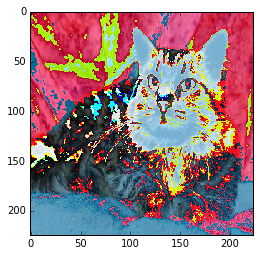

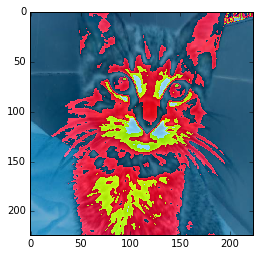

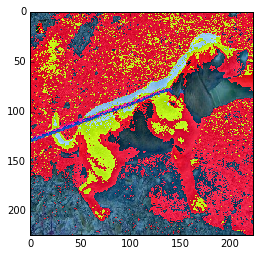

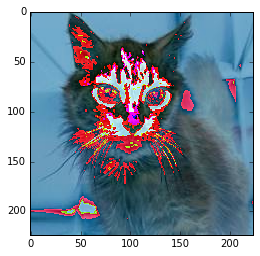

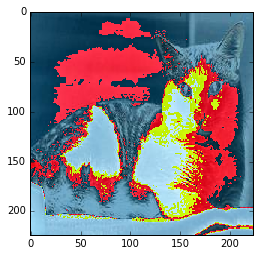

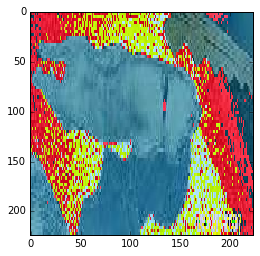

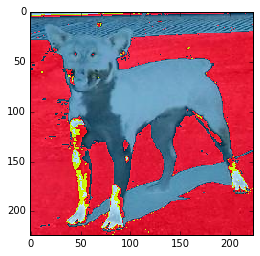

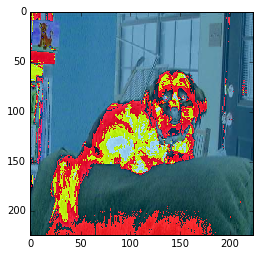

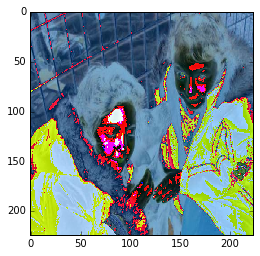

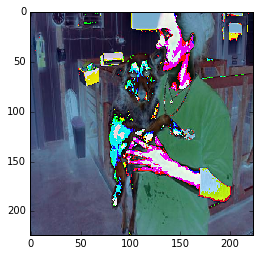

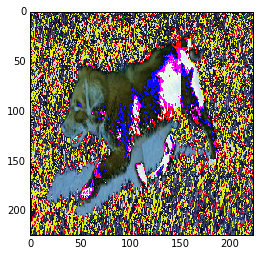

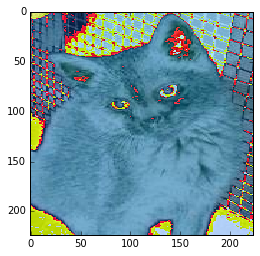

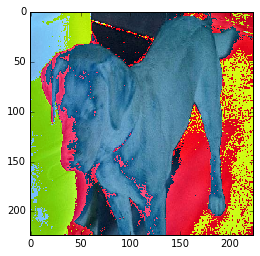

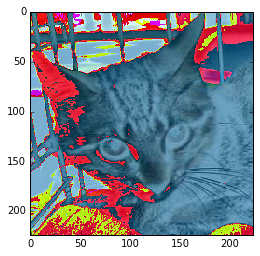

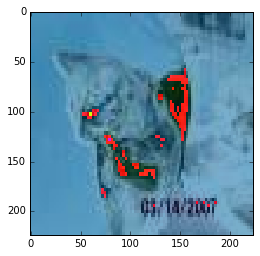

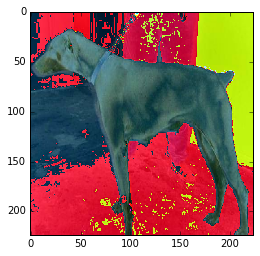

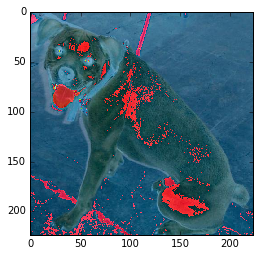

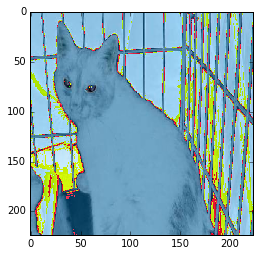

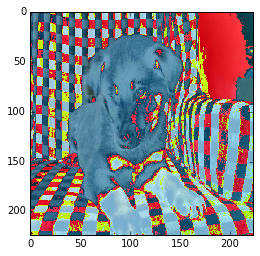

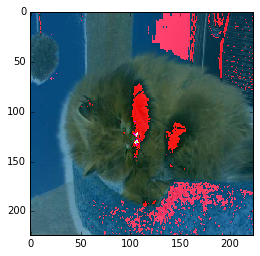

In [101]:
imgs,lbl=next(aug_train_batches)
for img in imgs:
    plt.figure()
    plt.imshow(img)

In [55]:
model.layers[-2].rate=0.0

In [103]:
model.evaluate_generator(valid_batches,steps=valid_batches.n/valid_batches.batch_size)

[0.1672089349195312, 0.98549999654293063]

In [104]:
pred=model.predict_generator(test_batches,steps=test_batches.n/test_batches.batch_size)

In [105]:
isdog=np.clip(pred[:,1],0.05,0.95)
ids=[ int(os.path.basename(f).split('.')[-2]) for f in test_batches.filenames]
sub=np.stack([ids,isdog],axis=1)
np.savetxt('trained2.csv',sub,fmt='%d,%.5f',header='id,label',comments='')

In [127]:
model.layers.insert(1,Lambda(lambda x: prepro(x)))


In [128]:
print(model.layers[0])
print(model.layers[1])
model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________


RuntimeError: You tried to call `count_params` on lambda_2, but the layer isn't built. You can build it manually via: `lambda_2.build(batch_input_shape)`.